In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


2025-05-05 17:55:15.244354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746467715.495358      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746467715.577007      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1/255.0,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  
    brightness_range=[0.8, 1.2],
    vertical_flip=False,
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
)

train_gen = data_gen.flow_from_directory(
    directory="/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size = (224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
)

test_gen = val_gen.flow_from_directory(
    directory = "/kaggle/input/brain-tumor-mri-dataset/Testing",
    target_size = (224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


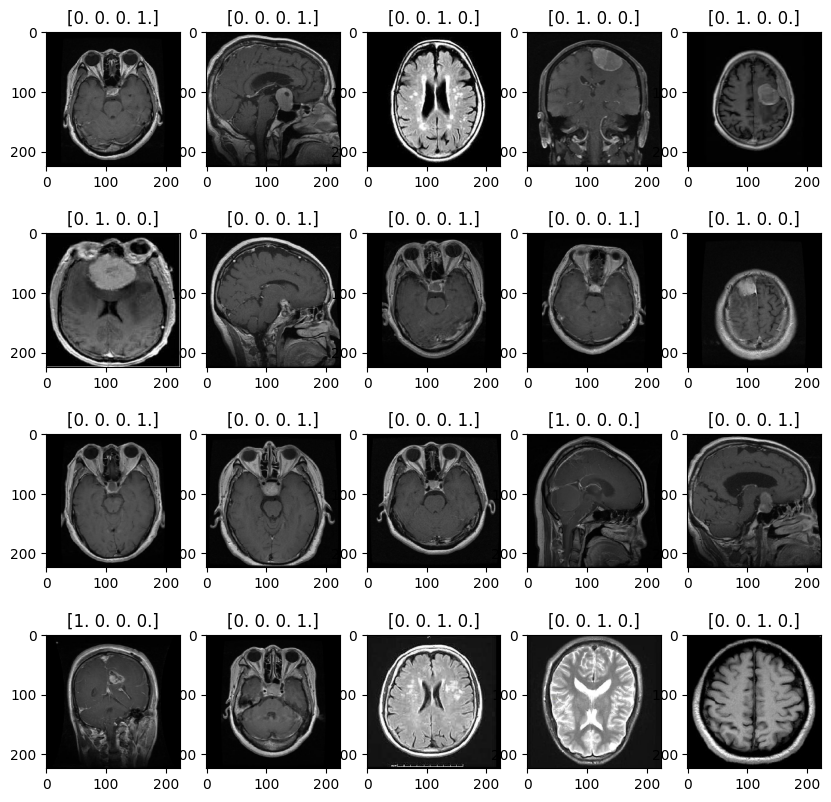

In [3]:
images,labels = next(test_gen)
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i])
    plt.title(str(labels[i]))
plt.show()

self-attention computes attention scores to determine how much focus each element in the sequence should have on the others. This is done using three key matrices:

Query (Q) – Represents the current word's relationship with others.
Key (K) – Represents the words that are being compared against.
Value (V) – Contains the actual word representations.
The self-attention is computed as:
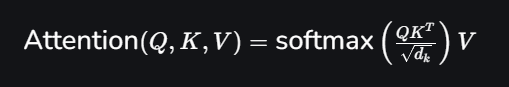

Multi-head attention extends self-attention by splitting the input into multiple heads, enabling the model to capture diverse relationships and patterns.

Instead of using a single set of Q,K,V matrices, the input embeddings are projected into multiple sets (heads), each with its own Q,K,V:

Linear Transformation: The input X is projected into multiple smaller-dimensional subspaces using different weight matrices.
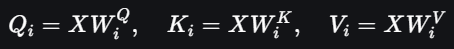

where iii denotes the head index.

Independent Attention Computation: Each head independently computes its own self-attention using the scaled dot-product formula.
Concatenation: The outputs from all heads are concatenated.
Final Linear Transformation: A final weight matrix is applied to transform the concatenated output into the desired dimension.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dim must be divisible by number of heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads

        # Linear layers for Q, K, V
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        
        # Final linear transformation after concatenation
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        # Split into (batch_size, num_heads, seq_len, projection_dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention_output, _ = self.attention(query, key, value)

        # Concatenate heads
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_output, (batch_size, -1, self.embed_dim))

        output = self.combine_heads(concat_attention)
        return output


In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Reshape, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D

input_layer = Input(shape=(224, 224, 3))
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_layer)
base_model.trainable = False 
x = base_model.output

x = GlobalAveragePooling2D()(x)
x_1 = Reshape((1,-1))(x)

embed_dim=1024
x_1 = Dense(embed_dim)(x_1)
x_att = MultiHeadSelfAttention(embed_dim,num_heads=8)(x_1)
x = GlobalAveragePooling1D()(x_att)  
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(16,activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(4,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=output)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')],
)
model.fit(train_gen,epochs=10,batch_size=32,validation_data=test_gen,
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=8,monitor='val_loss',mode='min',restore_best_weights=True)])


2025-05-05 17:55:38.902036: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 790s 4s/step - accuracy: 0.5675 - loss: 1.0847 - precision: 0.6487 - recall: 0.4109 - val_accuracy: 0.7902 - val_loss: 0.5580 - val_precision: 0.8446 - val_recall: 0.7544
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.7392 - loss: 0.7156 - precision: 0.8241 - recall: 0.6001 - val_accuracy: 0.8261 - val_loss: 0.4946 - val_precision: 0.8695 - val_recall: 0.7826
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 725s 4s/step - accuracy: 0.7518 - loss: 0.6739 - precision: 0.8442 - recall: 0.6341 - val_accuracy: 0.8429 - val_loss: 0.4956 - val_precision: 0.8820 - val_recall: 0.7864
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 698s 4s/step - accuracy: 0.7867 - loss: 0.6281 - precision: 0.8553 - recall: 0.6649 - val_accuracy: 0.8314 - val_loss: 0.4647 - val_precision: 0.8859 - val_recall: 0.7879
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 703s 4s/step - accuracy: 0.7946 - loss: 0.6015 - precision: 0.8725 - recall: 0.6878 - val_accuracy: 0.8284 - val_loss: 0.4734 -